## 1. Requirements

In [ ]:
import numpy as np
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from glob import glob
import os
import re
import shutil
from scipy import stats

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Set Args

In [ ]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

## 3. Prepare Data

In [ ]:
! git clone https://github.com/EliSchwartz/imagenet-sample-images.git

Cloning into 'imagenet-sample-images'...
remote: Enumerating objects: 1012, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 1012 (delta 3), reused 5 (delta 2), pack-reused 1002
Receiving objects: 100% (1012/1012), 103.84 MiB | 32.51 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
directory = '/content/data/imagenet/'
for image in glob('/content/imagenet-sample-images/*.JPEG'):
  folder = image[image.find('_')+1:].split('.JPEG')[0]
  if not os.path.exists(directory+folder):
    os.makedirs(directory+folder)

  source_path = image
  destination_path = directory+folder + '/1.jpg'

  # Move the image
  shutil.move(source_path, destination_path)  



In [ ]:
# https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
class_idx = json.load(open("./data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [ ]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
])

In [ ]:
def image_folder_custom_label(root, transform, custom_label) :
    
    # custom_label
    # type : List
    # index -> label
    # ex) ['tench', 'goldfish', 'great_white_shark', 'tiger_shark']
    
    old_data = dsets.ImageFolder(root = root, transform = transform)
    old_classes = old_data.classes
    
    label2idx = {}
    
    for i, item in enumerate(idx2label) :
        label2idx[item] = i
    
    new_data = dsets.ImageFolder(root = root, transform = transform, 
                                 target_transform = lambda x : custom_label.index(old_classes[x]))
    new_data.classes = idx2label
    new_data.class_to_idx = label2idx

    return new_data

In [ ]:
!rm -rf ./data/imagenet/.ipynb_checkpoints/

In [ ]:
normal_data = image_folder_custom_label(root = './data/imagenet/', transform = transform, custom_label = idx2label)
normal_loader = Data.DataLoader(normal_data, batch_size=1, shuffle=False)

In [ ]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

True Image & True Label


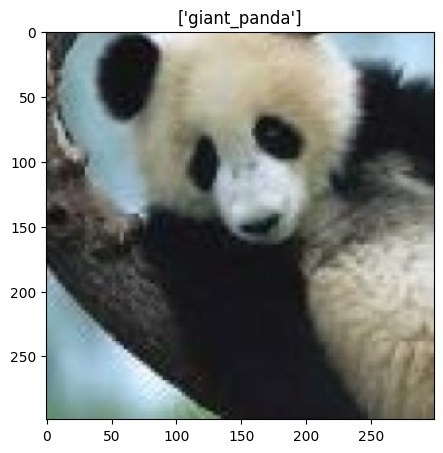

In [ ]:
normal_iter = iter(normal_loader)
images, labels = next(normal_iter)


print("True Image & True Label")
imshow(torchvision.utils.make_grid(images, normalize=True), [normal_data.classes[i] for i in labels])

## 4. Download the Inception v3

In [ ]:
model = models.inception_v3(pretrained=True).to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [ ]:
print("True Image & Predicted Label")

model.eval()

correct = 0
total = 0

for images, labels in normal_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    
    _, pre = torch.max(outputs.data, 1)
    
    total += 1
    correct += (pre == labels).sum()
    
    # imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
        
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

True Image & Predicted Label
Accuracy of test text: 100.000000 %


## 5. Standard Adversarial Attack

$$x^{t+1} = \Pi_{x+S}(x^t+\alpha sgn(\bigtriangledown_x L(\theta, x, y)))$$
* $S$ : a set of allowed perturbations

In [ ]:
# PGD Attack
# MNIST init
def pgd_attack(model, images, labels, eps=0.3, alpha=2/255, iters=1) :
    images = images.to(device)
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()
        
    ori_images = images.data
        
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()

        adv_images = images + alpha*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        # print(eta)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
            
    return images

In [ ]:
print("Attack Image & Predicted Label")

model.eval()

correct = 0
total = 0
attack_hops = 0
predict_correct = 0
for images, labels in normal_loader:

    print(f'ground truth label {[normal_data.classes[i] for i in labels]}')
    images = pgd_attack(model, images, labels)
    labels = labels.to(device)
    outputs = model(images)
    
    _, pre = torch.max(outputs.data, 1)



    total += 1

    correct += (pre == labels).sum()
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
    pred_l = []
    for i in range(attack_hops):
      images = pgd_attack(model, images, pre)
      labels = labels.to(device)
      outputs = model(images)
      
      _, pre = torch.max(outputs.data, 1)
      pred_l.append(pre.cpu().numpy())
      total += 1
      correct += (pre == labels).sum()
      
      predict = stats.mode(pred_l)[0][0][0]

      # imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
    predict_correct += 1

print('Accuracy of test text: %f %%' % (100 * float(correct) / total))
print('Accuracy of test text: %f %%' % (100 * float(predict_correct) / total))

## 6. PSGD Based Adversarial Attack

In [ ]:
#@title PSGD Code
"""Created in May, 2018
Pytorch functions for preconditioned SGD
@author: XILIN LI, lixilinx@gmail.com

Updated in Dec, 2020: 
Wrapped Kronecker product preconditioner for easy use: the code will select the proper Kronecker product  
preconditioner based on the formats of input left and right preconditioners.
Add torch.jit.script decorator by default
"""

import torch


###############################################################################
@torch.jit.script
def update_precond_dense(Q, dxs, dgs, step=0.01, _tiny=1.2e-38):
    # type: (Tensor, List[Tensor], List[Tensor], float, float) -> Tensor
    """
    update dense preconditioner P = Q^T*Q
    Q: Cholesky factor of preconditioner with positive diagonal entries 
    dxs: list of perturbations of parameters
    dgs: list of perturbations of gradients
    step: update step size normalized to range [0, 1] 
    _tiny: an offset to avoid division by zero 
    """
    dx = torch.cat([torch.reshape(x, [-1, 1]) for x in dxs])
    dg = torch.cat([torch.reshape(g, [-1, 1]) for g in dgs])
    
    a = Q.mm(dg)
    #b = torch.triangular_solve(dx, Q, upper=True, transpose=True)[0]
    b = torch.linalg.solve_triangular(Q.t(), dx, upper=False)

    grad = torch.triu(a.mm(a.t()) - b.mm(b.t()))
    step0 = step/(grad.abs().max() + _tiny)        
        
    return Q - step0*grad.mm(Q)

@torch.jit.script
def precond_grad_dense(Q, grads):
    # type: (Tensor, List[Tensor]) -> List[Tensor]
    """
    return preconditioned gradient using dense preconditioner
    Q: Cholesky factor of preconditioner
    grads: list of gradients
    """
    grad = [torch.reshape(g, [-1, 1]) for g in grads]
    lens = [g.shape[0] for g in grad]
    grad = torch.cat(grad)
    grad = Q.t().mm(Q.mm(grad))
    
    pre_grads = []
    idx = 0
    for i in range(len(grads)):
        pre_grads.append(torch.reshape(grad[idx : idx + lens[i]], grads[i].shape))
        idx = idx + lens[i]
        
    return pre_grads


###############################################################################
def update_precond_kron(Ql, Qr, dX, dG, step=0.01, _tiny=1.2e-38):
    """
    Update Kronecker product preconditioner P = kron_prod(Qr^T*Qr, Ql^T*Ql)
    Either Ql or Qr can be sparse, and the code can choose the right update rule.
    dX: perturbation of (matrix) parameter
    dG: perturbation of (matrix) gradient
    step: update step size
    _tiny: an offset to avoid division by zero 
    """
    m, n = Ql.shape
    p, q = Qr.shape
    if m==n: # left is dense
        if p==q: #(dense, dense) format
            return _update_precond_dense_dense(Ql, Qr, dX, dG, step, _tiny)
        elif p==2: # (dense, normalization) format
            return _update_precond_norm_dense(Qr, Ql, dX.t(), dG.t(), step, _tiny)[::-1]
        elif p==1: # (dense, scaling) format
            return _update_precond_dense_scale(Ql, Qr, dX, dG, step, _tiny)
        else:
            raise Exception('Unknown Kronecker product preconditioner')
    elif m==2: # left is normalization
        if p==q: # (normalization, dense) format
            return _update_precond_norm_dense(Ql, Qr, dX, dG, step, _tiny)
        elif p==1: # (normalization, scaling) format
            return _update_precond_norm_scale(Ql, Qr, dX, dG, step, _tiny)
        else:
            raise Exception('Unknown Kronecker product preconditioner')
    elif m==1: # left is scaling
        if p==q: # (scaling, dense) format
            return _update_precond_dense_scale(Qr, Ql, dX.t(), dG.t(), step, _tiny)[::-1]
        elif p==2: # (scaling, normalization) format
            return _update_precond_norm_scale(Qr, Ql, dX.t(), dG.t(), step, _tiny)[::-1]
        else:
            raise Exception('Unknown Kronecker product preconditioner')
    else:
        raise Exception('Unknown Kronecker product preconditioner')
 
       
def precond_grad_kron(Ql, Qr, Grad):
    """
    return preconditioned gradient using Kronecker product preconditioner P = kron_prod(Qr^T*Qr, Ql^T*Ql)
    Either Ql or Qr can be sparse, and the code can choose the right way to precondition the gradient
    Grad: (matrix) gradient
    """
    m, n = Ql.shape
    p, q = Qr.shape
    if m==n: # left is dense
        if p==q: #(dense, dense) format
            return _precond_grad_dense_dense(Ql, Qr, Grad)
        elif p==2: # (dense, normalization) format
            return _precond_grad_norm_dense(Qr, Ql, Grad.t()).t()
        elif p==1: # (dense, scaling) format
            return _precond_grad_dense_scale(Ql, Qr, Grad)
        else:
            raise Exception('Unknown Kronecker product preconditioner')
    elif m==2: # left is normalization
        if p==q: # (normalization, dense) format
            return _precond_grad_norm_dense(Ql, Qr, Grad)
        elif p==1: # (normalization, scaling) format
            return _precond_grad_norm_scale(Ql, Qr, Grad)
        else:
            raise Exception('Unknown Kronecker product preconditioner')
    elif m==1: # left is scaling
        if p==q: # (scaling, dense) format
            return _precond_grad_dense_scale(Qr, Ql, Grad.t()).t()
        elif p==2: # (scaling, normalization) format
            return _precond_grad_norm_scale(Qr, Ql, Grad.t()).t()
        else:
            raise Exception('Unknown Kronecker product preconditioner')
    else:
        raise Exception('Unknown Kronecker product preconditioner')
        

###############################################################################
@torch.jit.script
def _update_precond_dense_dense(Ql, Qr, dX, dG, step=0.01, _tiny=1.2e-38):
    # type: (Tensor, Tensor, Tensor, Tensor, float, float) -> Tuple[Tensor, Tensor]
    """
    update Kronecker product preconditioner P = kron_prod(Qr^T*Qr, Ql^T*Ql)
    Ql: (left side) Cholesky factor of preconditioner with positive diagonal entries
    Qr: (right side) Cholesky factor of preconditioner with positive diagonal entries
    dX: perturbation of (matrix) parameter
    dG: perturbation of (matrix) gradient
    step: update step size normalized to range [0, 1] 
    _tiny: an offset to avoid division by zero 
    """
    max_l = torch.max(torch.diag(Ql))
    max_r = torch.max(torch.diag(Qr))
    
    rho = torch.sqrt(max_l/max_r)
    Ql /= rho
    Qr *= rho
    
    #A = Ql.mm( dG.mm( Qr.t() ) )
    #Bt = torch.triangular_solve((torch.triangular_solve(dX.t(), Qr, upper=True, transpose=True))[0].t(), 
    #                 Ql, upper=True, transpose=True)[0]
    A = torch.linalg.multi_dot([Ql, dG, Qr.t()])
    Bt = torch.linalg.solve_triangular(Ql.t(), torch.linalg.solve_triangular(Qr, dX, upper=True, left=False), upper=False)
    
    grad1 = torch.triu(A.mm(A.t()) - Bt.mm(Bt.t()))
    grad2 = torch.triu(A.t().mm(A) - Bt.t().mm(Bt))
    
    step1 = step/(torch.max(torch.abs(grad1)) + _tiny)
    step2 = step/(torch.max(torch.abs(grad2)) + _tiny)
        
    return Ql - step1*grad1.mm(Ql), Qr - step2*grad2.mm(Qr)
    
@torch.jit.script
def _precond_grad_dense_dense(Ql, Qr, Grad):
    # type: (Tensor, Tensor, Tensor) -> Tensor
    """
    return preconditioned gradient using Kronecker product preconditioner
    Ql: (left side) Cholesky factor of preconditioner
    Qr: (right side) Cholesky factor of preconditioner
    Grad: (matrix) gradient
    """
    #return torch.chain_matmul(Ql.t(), Ql, Grad, Qr.t(), Qr)
    return torch.linalg.multi_dot([Ql.t(), Ql, Grad, Qr.t(), Qr])
    

###############################################################################
# (normalization, dense) format Kronecker product preconditioner
@torch.jit.script
def _update_precond_norm_dense(ql, Qr, dX, dG, step=0.01, _tiny=1.2e-38):
    # type: (Tensor, Tensor, Tensor, Tensor, float, float) -> Tuple[Tensor, Tensor]
    """
    update (normalization, dense) Kronecker product preconditioner P = kron_prod(Qr^T*Qr, Ql^T*Ql), where
    dX and dG have shape (M, N)
    ql has shape (2, M)
    Qr has shape (N, N)
    ql[0] is the diagonal part of Ql
    ql[1,0:-1] is the last column of Ql, excluding the last entry
    dX is perturbation of (matrix) parameter
    dG is perturbation of (matrix) gradient
    step: update step size normalized to range [0, 1] 
    _tiny: an offset to avoid division by zero  
    """
    # make sure that Ql and Qr have similar dynamic range
    max_l = torch.max(ql[0])
    max_r = torch.max(torch.diag(Qr))  
    rho = torch.sqrt(max_l/max_r)
    ql /= rho
    Qr *= rho
    
    # refer to https://arxiv.org/abs/1512.04202 for details
    A = ql[0:1].t()*dG + ql[1:].t().mm( dG[-1:] ) # Ql*dG 
    A = A.mm(Qr.t())
    
    Bt = dX/ql[0:1].t()
    Bt[-1:] -= (ql[1:]/(ql[0:1]*ql[0,-1])).mm(dX)
    #Bt = torch.triangular_solve(Bt.t(), Qr, upper=True, transpose=True)[0].t()
    Bt = torch.linalg.solve_triangular(Qr, Bt, upper=True, left=False)
    
    grad1_diag = torch.sum(A*A, dim=1) - torch.sum(Bt*Bt, dim=1)
    grad1_bias = A[:-1].mm(A[-1:].t()) - Bt[:-1].mm(Bt[-1:].t()) 
    grad1_bias = torch.cat([torch.squeeze(grad1_bias), grad1_bias.new_zeros(1)])  

    step1 = step/(torch.max(torch.max(torch.abs(grad1_diag)), 
                            torch.max(torch.abs(grad1_bias))) + _tiny)
    new_ql0 = ql[0] - step1*grad1_diag*ql[0]
    new_ql1 = ql[1] - step1*(grad1_diag*ql[1] + ql[0,-1]*grad1_bias)
    
    grad2 = torch.triu(A.t().mm(A) - Bt.t().mm(Bt))
    step2 = step/(torch.max(torch.abs(grad2)) + _tiny)
    
    return torch.stack((new_ql0, new_ql1)), Qr - step2*grad2.mm(Qr)

@torch.jit.script
def _precond_grad_norm_dense(ql, Qr, Grad):
    # type: (Tensor, Tensor, Tensor) -> Tensor
    """
    return preconditioned gradient using (normalization, dense) Kronecker product preconditioner 
    Suppose Grad has shape (M, N)
    ql[0] is the diagonal part of Ql
    ql[1, 0:-1] is the last column of Ql, excluding the last entry
    Qr: shape (N, N), Cholesky factor of right preconditioner
    Grad: (matrix) gradient
    """
    preG = ql[0:1].t()*Grad + ql[1:].t().mm(Grad[-1:]) # Ql*Grad 
    #preG = torch.chain_matmul(preG, Qr.t(), Qr)
    preG = torch.linalg.multi_dot([preG, Qr.t(), Qr])
    add_last_row = ql[1:].mm(preG) # use it to modify the last row
    preG *= ql[0:1].t()
    preG[-1:] += add_last_row
    
    return preG


###############################################################################
# (normalization, scaling) Kronecker product preconditioner 
# the left one is a normalization preconditioner; the right one is a scaling preconditioner
@torch.jit.script
def _update_precond_norm_scale(ql, qr, dX, dG, step=0.01, _tiny=1.2e-38):
    # type: (Tensor, Tensor, Tensor, Tensor, float, float) -> Tuple[Tensor, Tensor]
    """
    update (normalization, scaling) preconditioner P = kron_prod(Qr^T*Qr, Ql^T*Ql), where
    dX and dG have shape (M, N)
    ql has shape (2, M)
    qr has shape (1, N)
    ql[0] is the diagonal part of Ql
    ql[1, 0:-1] is the last column of Ql, excluding the last entry
    qr is the diagonal part of Qr
    dX is perturbation of (matrix) parameter
    dG is perturbation of (matrix) gradient
    step: update step size
    _tiny: an offset to avoid division by zero  
    """
    # make sure that Ql and Qr have similar dynamic range
    max_l = torch.max(ql[0])
    max_r = torch.max(qr) # qr always is positive
    rho = torch.sqrt(max_l/max_r)
    ql /= rho
    qr *= rho
    
    # refer to https://arxiv.org/abs/1512.04202 for details
    A = ql[0:1].t()*dG + ql[1:].t().mm( dG[-1:] ) # Ql*dG 
    A *= qr # Ql*dG*Qr 
    
    Bt = dX/ql[0:1].t()
    Bt[-1:] -= (ql[1:]/(ql[0:1]*ql[0,-1])).mm(dX)
    Bt /= qr # Ql^(-T)*dX*Qr^(-1) 
    
    grad1_diag = torch.sum(A*A, dim=1) - torch.sum(Bt*Bt, dim=1)
    grad1_bias = A[:-1].mm(A[-1:].t()) - Bt[:-1].mm(Bt[-1:].t()) 
    grad1_bias = torch.cat([torch.squeeze(grad1_bias), grad1_bias.new_zeros(1)])  

    step1 = step/(torch.max(torch.max(torch.abs(grad1_diag)), 
                            torch.max(torch.abs(grad1_bias))) + _tiny)
    new_ql0 = ql[0] - step1*grad1_diag*ql[0]
    new_ql1 = ql[1] - step1*(grad1_diag*ql[1] + ql[0,-1]*grad1_bias)
    
    grad2 = torch.sum(A*A, dim=0, keepdim=True) - torch.sum(Bt*Bt, dim=0, keepdim=True)
    step2 = step/(torch.max(torch.abs(grad2)) + _tiny)
    
    return torch.stack((new_ql0, new_ql1)), qr - step2*grad2*qr

@torch.jit.script
def _precond_grad_norm_scale(ql, qr, Grad):
    # type: (Tensor, Tensor, Tensor) -> Tensor
    """
    return preconditioned gradient using (normalization, scaling) Kronecker product preconditioner
    Suppose Grad has shape (M, N)
    ql has shape (2, M) 
    qr has shape (1, N) 
    ql[0] is the diagonal part of Ql
    ql[1, 0:-1] is the last column of Ql, excluding the last entry
    qr is the diagonal part of Qr
    Grad: (matrix) gradient
    """
    preG = ql[0:1].t()*Grad + ql[1:].t().mm(Grad[-1:]) # Ql*Grad 
    preG *= (qr*qr) # Ql*Grad*Qr^T*Qr
    add_last_row = ql[1:].mm(preG) # use it to modify the last row
    preG *= ql[0:1].t()
    preG[-1:] += add_last_row
    
    return preG


###############################################################################
@torch.jit.script
def _update_precond_dense_scale(Ql, qr, dX, dG, step=0.01, _tiny=1.2e-38):
    # type: (Tensor, Tensor, Tensor, Tensor, float, float) -> Tuple[Tensor, Tensor]
    """
    update (dense, scaling) preconditioner P = kron_prod(Qr^T*Qr, Ql^T*Ql), where
    dX and dG have shape (M, N)
    Ql has shape (M, M)
    qr has shape (1, N)
    qr is the diagonal part of Qr
    dX is perturbation of (matrix) parameter
    dG is perturbation of (matrix) gradient
    step: update step size
    _tiny: an offset to avoid division by zero 
    """
    max_l = torch.max(torch.diag(Ql))
    max_r = torch.max(qr)
    
    rho = torch.sqrt(max_l/max_r)
    Ql /= rho
    qr *= rho
    
    A = Ql.mm( dG*qr )
    #Bt = torch.triangular_solve(dX/qr, Ql, upper=True, transpose=True)[0]
    Bt = torch.linalg.solve_triangular(Ql.t(), dX/qr, upper=False)
    
    grad1 = torch.triu(A.mm(A.t()) - Bt.mm(Bt.t()))
    grad2 = torch.sum(A*A, dim=0, keepdim=True) - torch.sum(Bt*Bt, dim=0, keepdim=True)
    
    step1 = step/(torch.max(torch.abs(grad1)) + _tiny)
    step2 = step/(torch.max(torch.abs(grad2)) + _tiny)
        
    return Ql - step1*grad1.mm(Ql), qr - step2*grad2*qr
    
@torch.jit.script
def _precond_grad_dense_scale(Ql, qr, Grad):
    # type: (Tensor, Tensor, Tensor) -> Tensor
    """
    return preconditioned gradient using (dense, scaling) Kronecker product preconditioner
    Suppose Grad has shape (M, N)
    Ql: shape (M, M), (left side) Cholesky factor of preconditioner
    qr: shape (1, N), defines a diagonal matrix for output feature scaling
    Grad: (matrix) gradient
    """
    #return torch.chain_matmul(Ql.t(), Ql, Grad*(qr*qr))
    return torch.linalg.multi_dot([Ql.t(), Ql, Grad*(qr*qr)])



###############################################################################   
@torch.jit.script                     
def update_precond_splu(L12, l3, U12, u3, dxs, dgs, step=0.01, _tiny=1.2e-38):
    # type: (Tensor,Tensor,Tensor,Tensor, List[Tensor],List[Tensor], float,float) -> Tuple[Tensor,Tensor,Tensor,Tensor]
    """
    update sparse LU preconditioner P = Q^T*Q, where 
    Q = L*U,
    L12 = [L1; L2]
    U12 = [U1, U2]
    L = [L1, 0; L2, diag(l3)]
    U = [U1, U2; 0, diag(u3)]
    l3 and u3 are column vectors
    dxs: a list of random perturbation on parameters
    dgs: a list of resultant perturbation on gradients
    step: update step size normalized to range [0, 1] 
    _tiny: an offset to avoid division by zero 
    """
    # make sure that L and U have similar dynamic range
    max_l = torch.max(torch.max(torch.diag(L12)), torch.max(l3))
    max_u = torch.max(torch.max(torch.diag(U12)), torch.max(u3))
    rho = torch.sqrt(max_l/max_u)
    L12 /= rho
    l3 /= rho
    U12 *= rho
    u3 *= rho
    
    # extract the blocks
    r = U12.shape[0]
    L1 = L12[:r]
    L2 = L12[r:]
    U1 = U12[:, :r]
    U2 = U12[:, r:]
    
    dx = torch.cat([torch.reshape(x, [-1, 1]) for x in dxs]) # a tall column vector
    dg = torch.cat([torch.reshape(g, [-1, 1]) for g in dgs]) # a tall column vector
    
    # U*dg
    Ug1 = U1.mm(dg[:r]) + U2.mm(dg[r:])
    Ug2 = u3*dg[r:]
    # Q*dg
    Qg1 = L1.mm(Ug1)
    Qg2 = L2.mm(Ug1) + l3*Ug2
    # inv(U^T)*dx
    #iUtx1 = torch.triangular_solve(dx[:r], U1, upper=True, transpose=True)[0]
    iUtx1 = torch.linalg.solve_triangular(U1.t(), dx[:r], upper=False)
    iUtx2 = (dx[r:] - U2.t().mm(iUtx1))/u3
    # inv(Q^T)*dx
    iQtx2 = iUtx2/l3
    #iQtx1 = torch.triangular_solve(iUtx1 - L2.t().mm(iQtx2), L1, upper=False, transpose=True)[0]
    iQtx1 = torch.linalg.solve_triangular(L1.t(), iUtx1 - L2.t().mm(iQtx2), upper=True)
    # L^T*Q*dg
    LtQg1 = L1.t().mm(Qg1) + L2.t().mm(Qg2)
    LtQg2 = l3*Qg2
    # P*dg
    Pg1 = U1.t().mm(LtQg1)
    Pg2 = U2.t().mm(LtQg1) + u3*LtQg2
    # inv(L)*inv(Q^T)*dx
    #iLiQtx1 = torch.triangular_solve(iQtx1, L1, upper=False)[0]
    iLiQtx1 = torch.linalg.solve_triangular(L1, iQtx1, upper=False)
    iLiQtx2 = (iQtx2 - L2.mm(iLiQtx1))/l3
    # inv(P)*dx
    iPx2 = iLiQtx2/u3
    #iPx1 = torch.triangular_solve(iLiQtx1 - U2.mm(iPx2), U1, upper=True)[0]
    iPx1 = torch.linalg.solve_triangular(U1, iLiQtx1 - U2.mm(iPx2), upper=True)
    
    # update L
    grad1 = Qg1.mm(Qg1.t()) - iQtx1.mm(iQtx1.t())
    grad1 = torch.tril(grad1)
    grad2 = Qg2.mm(Qg1.t()) - iQtx2.mm(iQtx1.t())
    grad3 = Qg2*Qg2 - iQtx2*iQtx2
    max_abs_grad = torch.max(torch.abs(grad1))
    max_abs_grad = torch.max(max_abs_grad, torch.max(torch.abs(grad2)))
    max_abs_grad = torch.max(max_abs_grad, torch.max(torch.abs(grad3)))
    step0 = step/(max_abs_grad + _tiny)
    newL1 = L1 - step0*grad1.mm(L1)
    newL2 = L2 - step0*grad2.mm(L1) - step0*grad3*L2
    newl3 = l3 - step0*grad3*l3

    # update U
    grad1 = Pg1.mm(dg[:r].t()) - dx[:r].mm(iPx1.t())
    grad1 = torch.triu(grad1)
    grad2 = Pg1.mm(dg[r:].t()) - dx[:r].mm(iPx2.t())
    grad3 = Pg2*dg[r:] - dx[r:]*iPx2
    max_abs_grad = torch.max(torch.abs(grad1))
    max_abs_grad = torch.max(max_abs_grad, torch.max(torch.abs(grad2)))
    max_abs_grad = torch.max(max_abs_grad, torch.max(torch.abs(grad3)))
    step0 = step/(max_abs_grad + _tiny)
    newU1 = U1 - U1.mm(step0*grad1)
    newU2 = U2 - U1.mm(step0*grad2) - step0*grad3.t()*U2
    newu3 = u3 - step0*grad3*u3

    return torch.cat([newL1, newL2], dim=0), newl3, torch.cat([newU1, newU2], dim=1), newu3

@torch.jit.script
def precond_grad_splu(L12, l3, U12, u3, grads):
    # type: (Tensor,Tensor,Tensor,Tensor, List[Tensor]) -> List[Tensor]
    """
    return preconditioned gradient with sparse LU preconditioner
    where P = Q^T*Q, 
    Q = L*U,
    L12 = [L1; L2]
    U12 = [U1, U2]
    L = [L1, 0; L2, diag(l3)]
    U = [U1, U2; 0, diag(u3)]
    l3 and u3 are column vectors
    grads: a list of gradients to be preconditioned
    """
    grad = [torch.reshape(g, [-1, 1]) for g in grads] # a list of column vector
    lens = [g.shape[0] for g in grad] # length of each column vector
    grad = torch.cat(grad)  # a tall column vector
    
    r = U12.shape[0]
    L1 = L12[:r]
    L2 = L12[r:]
    U1 = U12[:, :r]
    U2 = U12[:, r:]    
    
    # U*g
    Ug1 = U1.mm(grad[:r]) + U2.mm(grad[r:])
    Ug2 = u3*grad[r:]
    # Q*g
    Qg1 = L1.mm(Ug1)
    Qg2 = L2.mm(Ug1) + l3*Ug2
    # L^T*Q*g
    LtQg1 = L1.t().mm(Qg1) + L2.t().mm(Qg2)
    LtQg2 = l3*Qg2
    # P*g
    pre_grad = torch.cat([U1.t().mm(LtQg1),
                          U2.t().mm(LtQg1) + u3*LtQg2])
    
    pre_grads = [] # restore pre_grad to its original shapes
    idx = 0
    for i in range(len(grads)):
        pre_grads.append(torch.reshape(pre_grad[idx : idx + lens[i]], grads[i].shape))
        idx = idx + lens[i]
    
    return pre_grads



##############################################################################
#
# The UVd preconditioner is defined by
#
#   Q = (I + U*V')*diag(d)
#
# which, after reparameterization, is equivalent to form
#
#   diag(d) + U*V'
# 
# It relates to the LM-BFGS and conjugate gradient methods. 
#
# The JIT decorator can enabled if helps. 
# 

#@torch.jit.script
def IpUVtmatvec(U, V, x):
    # type: (Tensor, Tensor, Tensor) -> Tensor
    """
    Returns (I + U*V')*x. All variables are either matrices or column vectors. 
    """
    return x + U.mm(V.t().mm(x))

# def IpUVtsolve(U, V, x):
#     """
#     Returns inv(I + U*V')*x. All variables are either matrices or column vectors.
#     """
#     VtU = V.t().mm(U)
#     I = torch.eye(VtU.size(dim=0), dtype=VtU.dtype, device=VtU.device)
#     return x - U.mm(torch.linalg.solve(I + VtU, V.t().mm(x))) # solve is too slow!

# def norm_UVt(U, V):
#     """
#     Returns ||U*V'||_fro = sqrt(tr(U'*U*V'*V)) = sqrt(sum((U'*U)*(V'*V))) 
#     """
#     return torch.sqrt(torch.abs(torch.sum( (U.t().mm(U))*(V.t().mm(V)) )))

#@torch.jit.script
def update_precond_UVd_math(U, V, d, v, h, step=0.01, _tiny=1.2e-38):
    # type: (Tensor, Tensor, Tensor, Tensor, Tensor, float, float) -> List[Tensor]
    """
    Update preconditioner Q = (I + U*V')*diag(d) with (vector, Hessian-vector product) = (v, h).
                               
    U, V, d, v, and h are either matrices or column vectors.  
    """
    # balance the numerical dynamic ranges of U and V
    if torch.rand([]) < 0.01:
        maxU, maxV = torch.max(torch.abs(U)), torch.max(torch.abs(V))
        rho = torch.sqrt(maxU/maxV)
        U, V = U/rho, rho*V

    Qh = IpUVtmatvec(U, V, d*h)
    Ph = d*IpUVtmatvec(V, U, Qh)
    
    # invQtv = IpUVtsolve(V, U, v/d)
    # invPv = IpUVtsolve(U, V, invQtv)/d
    VtU = V.t().mm(U)
    I = torch.eye(VtU.size(dim=0), dtype=VtU.dtype, device=VtU.device)
    IpVtU = I + VtU
    invQtv = v/d
    # torch uses LU decomposition for linalg.solve; slow even for tiny mtx
    invQtv = invQtv - V.mm(torch.linalg.solve(IpVtU.t(), U.t().mm(invQtv)))  
    invPv  = invQtv - U.mm(torch.linalg.solve(IpVtU,     V.t().mm(invQtv)))
    invPv = invPv/d

    nablaD = Ph*h - v*invPv
    mu = step/(torch.max(torch.abs(nablaD)) + _tiny)
    d = d - mu*d*nablaD
    
    # update either U or V, not both at the same time
    if torch.rand([]) < 0.5:
        # nablaU = Qh.mm(Qh.t().mm(V)) - invQtv.mm(invQtv.t().mm(V))
        # mu = step/(norm_UVt(nablaU, V) + _tiny)
        # U = U - mu*(nablaU + nablaU.mm(V.t().mm(U)))
        a, b = Qh, invQtv
        atV = a.t().mm(V)
        atVVt = atV.mm(V.t())
        btV = b.t().mm(V)
        btVVt = btV.mm(V.t())
        norm = torch.sqrt(torch.abs( (a.t().mm(a))*(atVVt.mm(atVVt.t())) # abs to avoid sqrt(-0.0) 
                                    +(b.t().mm(b))*(btVVt.mm(btVVt.t())) 
                                  -2*(a.t().mm(b))*(atVVt.mm(btVVt.t())) ))
        mu = step/(norm + _tiny)
        U = U - mu*( a.mm(atV.mm(IpVtU)) 
                    -b.mm(btV.mm(IpVtU)) )
    else:
        # nablaV = Qh.mm(Qh.t().mm(U)) - invQtv.mm(invQtv.t().mm(U))
        # mu = step/(norm_UVt(U, nablaV) + _tiny)
        # V = V - mu*(nablaV + V.mm(U.t().mm(nablaV)))
        a, b = Qh, invQtv
        atU = a.t().mm(U)
        btU = b.t().mm(U)
        UUta = U.mm(atU.t())
        UUtb = U.mm(btU.t())
        norm = torch.sqrt(torch.abs( (UUta.t().mm(UUta))*(a.t().mm(a)) # abs to avoid sqrt(-0.0)
                                    +(UUtb.t().mm(UUtb))*(b.t().mm(b))
                                  -2*(UUta.t().mm(UUtb))*(a.t().mm(b)) ))
        mu = step/(norm + _tiny)
        V = V - mu*( (a + V.mm(atU.t())).mm(atU) 
                    -(b + V.mm(btU.t())).mm(btU) )

    return [U, V, d]

#@torch.jit.script
def precond_grad_UVd_math(U, V, d, g):
    # type: (Tensor, Tensor, Tensor, Tensor) -> Tensor
    """
    Preconditioning gradient g with Q = (I + U*V')*diag(d).
                                         
    All variables here are either matrices or column vectors. 
    """
    g = IpUVtmatvec(U, V, d*g)
    g = d*IpUVtmatvec(V, U, g)
    return g


def update_precond_UVd_math_(U, V, d, v, h, step, tiny):
    # type: (Tensor, Tensor, Tensor, Tensor, Tensor, float, float) -> None
    """
    Update preconditioner Q = (I + U*V')*diag(d) with (vector, Hessian-vector product) = (v, h).
    State variables U, V and d are updated inplace. 
                               
    U, V, d, v, and h are either matrices or column vectors.  
    """
    # balance the numerical dynamic ranges of U and V; optional 
    if torch.rand([]) < 0.01:
        normU = torch.linalg.vector_norm(U)
        normV = torch.linalg.vector_norm(V)
        rho = torch.sqrt(normU/normV)
        U.div_(rho)
        V.mul_(rho)

    Qh = IpUVtmatvec(U, V, d*h)
    Ph = d*IpUVtmatvec(V, U, Qh)
    
    # invQtv = IpUVtsolve(V, U, v/d)
    # invPv = IpUVtsolve(U, V, invQtv)/d
    VtU = V.t().mm(U)
    I = torch.eye(VtU.size(dim=0), dtype=VtU.dtype, device=VtU.device)
    IpVtU = I + VtU
    invQtv = v/d
    # torch's linalg.solve is slow for small matrix
    invQtv = invQtv - V.mm(torch.linalg.solve(IpVtU.t(), U.t().mm(invQtv)))  
    invPv  = invQtv - U.mm(torch.linalg.solve(IpVtU,     V.t().mm(invQtv)))
    invPv = invPv/d

    nablaD = Ph*h - v*invPv
    mu = step/(torch.max(torch.abs(nablaD)) + tiny)
    #d = d - mu*d*nablaD
    d.sub_(mu*d*nablaD)
    
    # update either U or V, not both at the same time
    a, b = Qh, invQtv
    if torch.rand([]) < 0.5:
        # nablaU = Qh.mm(Qh.t().mm(V)) - invQtv.mm(invQtv.t().mm(V))
        # mu = step/(norm_UVt(nablaU, V) + _tiny)
        # U = U - mu*(nablaU + nablaU.mm(V.t().mm(U)))
        atV = a.t().mm(V)
        atVVt = atV.mm(V.t())
        btV = b.t().mm(V)
        btVVt = btV.mm(V.t())
        norm = torch.sqrt(torch.abs( (a.t().mm(a))*(atVVt.mm(atVVt.t())) # abs to avoid sqrt(-0.0) 
                                    +(b.t().mm(b))*(btVVt.mm(btVVt.t())) 
                                  -2*(a.t().mm(b))*(atVVt.mm(btVVt.t())) ))
        mu = step/(norm + tiny)
        # U = U - mu*( a.mm(atV.mm(IpVtU)) 
        #             -b.mm(btV.mm(IpVtU)) )
        U.sub_(mu*( a.mm(atV.mm(IpVtU)) 
                   -b.mm(btV.mm(IpVtU)) ))
    else:
        # nablaV = Qh.mm(Qh.t().mm(U)) - invQtv.mm(invQtv.t().mm(U))
        # mu = step/(norm_UVt(U, nablaV) + _tiny)
        # V = V - mu*(nablaV + V.mm(U.t().mm(nablaV)))
        atU = a.t().mm(U)
        btU = b.t().mm(U)
        UUta = U.mm(atU.t())
        UUtb = U.mm(btU.t())
        norm = torch.sqrt(torch.abs( (UUta.t().mm(UUta))*(a.t().mm(a)) # abs to avoid sqrt(-0.0)
                                    +(UUtb.t().mm(UUtb))*(b.t().mm(b))
                                  -2*(UUta.t().mm(UUtb))*(a.t().mm(b)) ))
        mu = step/(norm + tiny)
        # V = V - mu*( (a + V.mm(atU.t())).mm(atU) 
        #             -(b + V.mm(btU.t())).mm(btU) )
        V.sub_(mu*( (a + V.mm(atU.t())).mm(atU) 
                   -(b + V.mm(btU.t())).mm(btU) ))

def update_precond_Xmat_math(a, b, v, h, step, tiny):
    # type: (Tensor, Tensor, Tensor, Tensor, float, float) -> None
    """
    Update preconditioner Q = diag(a) + adiag(b) with (vector, Hessian-vector product) = (v, h).
    State variables a and b are updated inplace.
    """
    Qh = a*h + b*torch.flip(h, [0])
    aflip, bflip = torch.flip(a, [0]), torch.flip(b, [0])
    invQtv = (aflip*v - bflip*torch.flip(v, [0]))/(a*aflip - b*bflip)
    nablaA = Qh*Qh - invQtv*invQtv
    nablaB = Qh*torch.flip(Qh, [0]) - invQtv*torch.flip(invQtv, [0])
    q, r = divmod(len(nablaB), 2)
    if r == 1:
        nablaB[q] = 0

    mu = step/(torch.maximum(torch.max(torch.abs(nablaA)), torch.max(torch.abs(nablaB))) + tiny)
    a.sub_(mu*(nablaA*a + nablaB*bflip))
    b.sub_(mu*(nablaA*b + nablaB*aflip))
    return a, b

#@torch.jit.script
def update_precond_UVd(UVd, vs, hs, step=0.01, _tiny=1.2e-38):
    # type: (Tensor, List[Tensor], List[Tensor], float, float) -> Tensor
    """
    update UVd preconditioner Q = (I + U*V')*diag(d) with
    vs: a list of vectors;
    hs: a list of associated Hessian-vector products;
    step: step size, setting to larger values, say 0.1, if updating is sparse;
    _tiny: an offset to avoid divided by zero. 
    
    It is a wrapped version of function update_precond_UVd_math for easy use. 
    Also, U, V, and d are transposed (row-major order as Python convention), and 
    packaged into one tensor. 
    """ 
    sizes = [len(UVd)//2]*2 + [1]
    U, V, d = torch.split(UVd.t(), sizes, dim=1)

    v = torch.cat([torch.flatten(v) for v in vs])
    h = torch.cat([torch.flatten(h) for h in hs])
    # U, V, d = update_precond_UVd_math(U, V, d, v[:,None], h[:,None], step=step, _tiny=_tiny)
    update_precond_UVd_math_(U, V, d, v[:,None], h[:,None], step=step, tiny=_tiny)
    return torch.cat([U, V, d], 1).t()


#@torch.jit.script
def precond_grad_UVd(UVd, grads):
    # type: (Tensor, List[Tensor]) -> List[Tensor]
    """
    return preconditioned gradient with UVd preconditioner Q = (I + U*V')*diag(d),
    and a list of gradients, grads.
    
    It is a wrapped version of function precond_grad_UVd_math for easy use.
    Also, U, V, and d are transposed (row-major order as Python convention), and 
    packaged into one tensor.
    """
    sizes = [len(UVd)//2]*2 + [1]
    U, V, d = torch.split(UVd.t(), sizes, dim=1)
    # a = torch.ones(num_params, dtype=dtype, device=device)*preconditioner_init_scale
    # b = torch.zeros(num_params, dtype=dtype, device=device)    

    # record the sizes and shapes, and then flatten gradients
    sizes = [torch.numel(g) for g in grads]
    shapes = [g.shape for g in grads]
    cumsizes = torch.cumsum(torch.tensor(sizes), 0)
    
    grad = torch.cat([torch.flatten(g) for g in grads])

    # precondition gradients
    pre_grad = precond_grad_UVd_math(U, V, d, grad[:,None])

    # restore gradients to their original shapes
    return [torch.reshape(pre_grad[j-i:j], s) for (i, j, s) in zip(sizes, cumsizes, shapes)]

#@torch.jit.script
def update_precond_Xmat_math_(a, b, v, h, step, tiny):
    # type: (Tensor, Tensor, Tensor, Tensor, float, float) -> None
    """
    Update preconditioner Q = diag(a) + adiag(b) with (vector, Hessian-vector product) = (v, h).
    State variables a and b are updated inplace.
    """
    Qh = a*h + b*torch.flip(h, [0])
    aflip, bflip = torch.flip(a, [0]), torch.flip(b, [0])
    invQtv = (aflip*v - bflip*torch.flip(v, [0]))/(a*aflip - b*bflip)
    nablaA = Qh*Qh - invQtv*invQtv
    nablaB = Qh*torch.flip(Qh, [0]) - invQtv*torch.flip(invQtv, [0])
    q, r = divmod(len(nablaB), 2)
    if r == 1:
        nablaB[q] = 0

    mu = step/(torch.maximum(torch.max(torch.abs(nablaA)), torch.max(torch.abs(nablaB))) + tiny)
    a.sub_(mu*(nablaA*a + nablaB*bflip))
    b.sub_(mu*(nablaA*b + nablaB*aflip))

#@torch.jit.script
def precond_grad_Xmat_math(a, b, g):
    # type: (Tensor, Tensor, Tensor) -> Tensor
    """
    Preconditioning gradient g with Q = diag(a) + adiag(b).
    """
    ab = a * b
    return (a*a + torch.flip(b*b, [0]))*g + (ab + torch.flip(ab, [0]))*torch.flip(g, [0])

def update_precond_Xmat_math_(a, b, v, h, step, tiny):
    # type: (Tensor, Tensor, Tensor, Tensor, float, float) -> None
    """
    Update preconditioner Q = diag(a) + adiag(b) with (vector, Hessian-vector product) = (v, h).
    State variables a and b are updated inplace.
    """
    Qh = a*h + b*torch.flip(h, [0])
    aflip, bflip = torch.flip(a, [0]), torch.flip(b, [0])
    invQtv = (aflip*v - bflip*torch.flip(v, [0]))/(a*aflip - b*bflip)
    nablaA = Qh*Qh - invQtv*invQtv
    nablaB = Qh*torch.flip(Qh, [0]) - invQtv*torch.flip(invQtv, [0])
    q, r = divmod(len(nablaB), 2)
    if r == 1:
        nablaB[q] = 0

    mu = step/(torch.maximum(torch.max(torch.abs(nablaA)), torch.max(torch.abs(nablaB))) + tiny)
    a.sub_(mu*(nablaA*a + nablaB*bflip))
    b.sub_(mu*(nablaA*b + nablaB*aflip))

#@torch.jit.script
def update_precond_XMat(a,b, vs, hs, step=0.01, _tiny=1.2e-38):
    # type: (Tensor, List[Tensor], List[Tensor], float, float) -> Tensor
    """
    update XMat preconditioner Q = diag(a) + adiag(b) with
    vs: a list of vectors;
    hs: a list of associated Hessian-vector products;
    step: step size, setting to larger values, say 0.1, if updating is sparse;
    _tiny: an offset to avoid divided by zero. 
    
    It is a wrapped version of function update_precond_XMat_math for easy use. 
    """ 

    v = torch.cat([torch.flatten(v) for v in vs])
    h = torch.cat([torch.flatten(h) for h in hs])
    # U, V, d = update_precond_UVd_math(U, V, d, v[:,None], h[:,None], step=step, _tiny=_tiny)
    # update_precond_UVd_math_(U, V, d, v[:,None], h[:,None], step=step, tiny=_tiny)
    # a, b =  update_precond_Xmat_math(a, b, v, h, step=step, tiny=_tiny)       
    update_precond_Xmat_math_(a, b, v, h, step=step, tiny=_tiny)       
    return a, b

#@torch.jit.script
def precond_grad_XMat(a,b, grads):
    # type: (Tensor, List[Tensor]) -> List[Tensor]
    """
    return preconditioned gradient with UVd preconditioner Q = (I + U*V')*diag(d),
    and a list of gradients, grads.
    
    It is a wrapped version of function precond_grad_UVd_math for easy use.
    Also, U, V, and d are transposed (row-major order as Python convention), and 
    packaged into one tensor.
    """

    # a = torch.ones(num_params,  device=device)
    # b = torch.zeros(num_params, device=device)    

    # record the sizes and shapes, and then flatten gradients
    sizes = [torch.numel(g) for g in grads]
    shapes = [g.shape for g in grads]
    cumsizes = torch.cumsum(torch.tensor(sizes), 0)
    
    grad = torch.cat([torch.flatten(g) for g in grads])

    # precondition gradients
    pre_grad =  precond_grad_Xmat_math(a, b, grad)

    # restore gradients to their original shapes
    return [torch.reshape(pre_grad[j-i:j], s) for (i, j, s) in zip(sizes, cumsizes, shapes)]

################## end of UVd preconditioner #################################

$$x^{t+1} = \Pi_{x+S}(x^t+\alpha sgn(P^{-1}\bigtriangledown_x L(\theta, x, y)))$$
* $S$ : a set of allowed perturbations
* Where P is either X-Mat or UVd 

In [ ]:
#@title Projected Preconditioned (X-Mat) Gradient Descent Attack 
# MNIST init
preconditioner_init_scale = 1.0
num_params = sum([torch.numel(W) for W in images])
a = torch.ones(num_params, device='cuda:0')*preconditioner_init_scale
b = torch.zeros(num_params, device='cuda:0') 
ce = nn.CrossEntropyLoss()
def pgd_attack(model, images, labels, eps=0.3, alpha=2/255, iters=1,a=None,b=None) :
    images = images.to(device)
    labels = labels.to(device)
    
        
    ori_images = images.data
    grad_norm_clip_thr = 100        
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        # model.zero_grad()
        loss = ce(outputs, labels).to(device)
        grads = torch.autograd.grad(loss, images, create_graph=True)
        vs = torch.randn_like(images)
        Hvs = torch.autograd.grad(grads, images, vs) 
        with torch.no_grad():
            a,b = update_precond_XMat(a,b, vs, Hvs)
            pre_grads = precond_grad_XMat(a,b, grads)
            # grad_norm = torch.sqrt(sum([torch.sum(g*g) for g in pre_grads]))
            # lr_adjust = min(grad_norm_clip_thr/grad_norm, 1.0)


        adv_images = images + alpha*pre_grads[0].sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
        # images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
            
    return images

Attack Image & Predicted Label


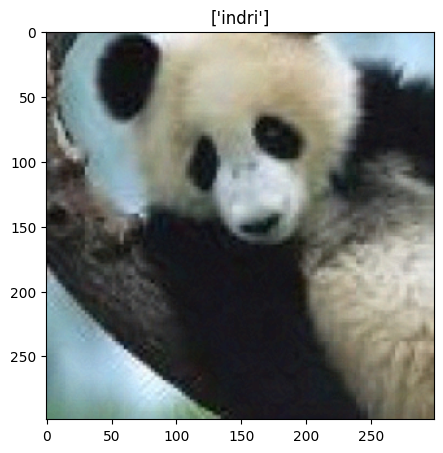

Accuracy of test text: 0.000000 %


In [ ]:
print("Attack Image & Predicted Label")

model.eval()

correct = 0
total = 0
attack_hops = 0
for images, labels in normal_loader:
    

    images = pgd_attack(model, images, labels,a=a,b=b)
    labels = labels.to(device)
    outputs = model(images)
    
    _, pre = torch.max(outputs.data, 1)

    total += 1
    correct += (pre == labels).sum()
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])

    for i in range(attack_hops):
      images = pgd_attack(model, images, pre,a=a,b=b)
      labels = labels.to(device)
      outputs = model(images)
      
      _, pre = torch.max(outputs.data, 1)

      total += 1
      correct += (pre == labels).sum()
      
      # imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])


    
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))


In [ ]:
#@title Projected Preconditioned (UVd) Gradient Descent Attack
# MNIST init
preconditioner_init_scale = 0.5
num_paras = sum([torch.numel(W) for W in images])
order_UVd = 10
UVd = torch.cat([torch.randn(2*order_UVd, num_paras)/(order_UVd*num_paras)**0.5,
                 torch.ones(1, num_paras)*preconditioner_init_scale], dim=0).to(device)
ce = nn.CrossEntropyLoss()
def pgd_attack(model, images, labels, eps=0.3, alpha=2/255, iters=2,UVd=None) :
    images = images.to(device)
    labels = labels.to(device)
    
        
    ori_images = images.data
    grad_norm_clip_thr = 100        
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        loss = ce(outputs, labels).to(device)
        grads = torch.autograd.grad(loss, images, create_graph=True)
        vs = torch.randn_like(images)
        Hvs = torch.autograd.grad(grads, images, vs) 
        with torch.no_grad():
            UVd = update_precond_UVd(UVd, vs, Hvs)
            pre_grads = precond_grad_UVd(UVd, grads)
            # grad_norm = torch.sqrt(sum([torch.sum(g*g) for g in pre_grads]))
            # lr_adjust = min(grad_norm_clip_thr/grad_norm, 1.0)


        adv_images = images + alpha*pre_grads[0].sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
        # images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
            
    return images

Attack Image & Predicted Label


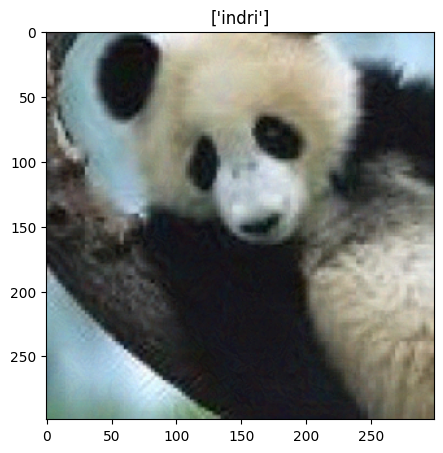

Accuracy of test text: 0.000000 %


In [ ]:
print("Attack Image & Predicted Label")

model.eval()

correct = 0
total = 0
attack_hops = 0
for images, labels in normal_loader:
    
    images = pgd_attack(model, images, labels,UVd=UVd)
    labels = labels.to(device)
    outputs = model(images)
    
    _, pre = torch.max(outputs.data, 1)

    total += 1
    correct += (pre == labels).sum()
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])

    for i in range(attack_hops):
      images = pgd_attack(model, images, pre,UVd=UVd)
      labels = labels.to(device)
      outputs = model(images)
      
      _, pre = torch.max(outputs.data, 1)

      total += 1
      correct += (pre == labels).sum()
      
      # imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])


    
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))
